Update: Increase quantity of labeled and unlabeled documents in training data set.

In [1]:
# Import packages and libraries
import numpy as np
import random as rnd
import re
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn import metrics

from time import time
from pprint import pprint
from copy import deepcopy
from wordcloud import WordCloud 
from Semi_EM_NB import Semi_EM_MultinomialNB
from os import path
from PIL import Image

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
def remove_noise(sentence):
    result = ''
    poster = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stopword_set = set(stopwords.words('english'))
    wordlist = re.sub(r"\n|(\\(.*?){)|}|[!$%^&*#()_+|~\-={}\[\]:\";'<>?,.\/\\]|[0-9]|[@]", ' ', sentence) # remove punctuation
    wordlist = re.sub('\s+', ' ', wordlist) # remove extra space
    wordlist_normal = [poster.stem(word.lower()) for word in wordlist.split()] # restore word to its original form (stemming)
    wordlist_normal = [lemmatizer.lemmatize(word, pos='v') for word in wordlist_normal] # restore word to its root form (lemmatization)
    wordlist_clean = [word for word in wordlist_normal if word not in stopword_set] # remove stopwords
    result = ' '.join(wordlist_clean)
    return result

In [3]:
def cross_validation(clf, data_X, data_y, unlabeled=None, n_folds=5):
    print('=' * 80)
    print("Validation: ")
    print(clf)
    kf = StratifiedKFold(n_splits=n_folds)
    start_time = time()
    train_accuracies= list() # training accuracy
    fold_count = 1
    original_clf = deepcopy(clf)
    for train_ids, valid_ids in kf.split(data_X, data_y):
        cv_clf = deepcopy(original_clf)
        print("Fold # %d" % fold_count)
        fold_count += 1
        train_X, train_y, valid_X, valid_y = data_X[train_ids], data_y[train_ids], data_X[valid_ids], data_y[valid_ids]
        if unlabeled==None:
            cv_clf.fit(train_X, train_y)
        else:
            cv_clf.fit(train_X, train_y, unlabeled)
        pred = cv_clf.predict(valid_X)
        train_accuracies.append(metrics.accuracy_score(valid_y, pred))
    train_time = time() - start_time
    print("Validation time: %0.3f seconds" % train_time)
    print("Average training accuracy: %0.3f" % np.mean(np.array(train_accuracies)))
    return train_accuracies, train_time

In [4]:
def show_topK(classifier, vectorizer, categories, K=10):
    feature_names = np.asarray(vectorizer.get_feature_names())
    nrows, ncols = 5, 4
    fig, axes = plt.subplots(figsize=(50, 40), nrows=nrows, ncols=ncols)
    #d = path.dirname(__file__)
    circle_mask = np.array(Image.open(path.join('./', "circle.png")))
    for i, category in enumerate(categories):
        topK = np.argsort(classifier.coef_[i])[-K:]
        text = " ".join(feature_names[topK])
        print("%s: %s" % (category, text))
        wordcloud = WordCloud(background_color="white", mask=circle_mask).generate(text)
        axes[i//ncols, i%ncols].imshow(wordcloud, cmap=plt.cm.cool_r, interpolation='bilinear')
        axes[i//ncols, i%ncols].axis("off")
        axes[i//ncols, i%ncols].set_title(category, fontweight="bold", size=24)
    plt.show()

In [5]:
# Load data set with class labels and split into train and test set
test_size_ratio = 0.2
data_Xy = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True)
category_names = data_Xy.target_names # text names of all categories
train_X, test_X, train_y, test_y = train_test_split(data_Xy.data, data_Xy.target, test_size=test_size_ratio, stratify=data_Xy.target)
print("Training set size: %8d\tTest set size: %8d" % (len(train_X), len(test_X)))

Training set size:    15076	Test set size:     3770


In [6]:
# preprocess train and test text data
train_X_clean = map(remove_noise, train_X)
test_X_clean = map(remove_noise, test_X)

In [7]:
# Convert all text data into tf-idf vectors 
vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.95)
# vectorizer = TfidfVectorizer()
train_vec = vectorizer.fit_transform(train_X_clean)
test_vec = vectorizer.transform(test_X_clean)
print train_vec.shape, test_vec.shape

(15076, 13497) (3770, 13497)


In [8]:
# Divide train data set into labeled and unlabeled data sets
split_ratio = 0.1 # labeled vs total(labeled+unlabeled)
X_l, X_u, y_l, y_u = train_test_split(train_vec, train_y, train_size=split_ratio, stratify=train_y)
print X_l.shape, X_u.shape

(1507, 13497) (13569, 13497)


In [9]:
# Cross validation for Naive Bayes classifier 
# using labeled data set only
nb_clf = MultinomialNB(alpha=1e-2)
cross_validation(nb_clf, X_l, y_l)

Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.080 seconds
Average training accuracy: 0.621


([0.60784313725490191,
  0.6143790849673203,
  0.57894736842105265,
  0.62333333333333329,
  0.68041237113402064],
 0.08025312423706055)

In [10]:
# Cross validation for semisupervised EM Naive Bayes classifier 
# using both labeled and unlabeled data set
em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2, tol=100, print_log_lkh=False) # semi supervised EM based Naive Bayes classifier
cross_validation(em_nb_clf, X_l, y_l, X_u)

Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 161.427 seconds
Average training accuracy: 0.690


([0.70261437908496727,
  0.65032679738562094,
  0.65131578947368418,
  0.69666666666666666,
  0.74914089347079038],
 161.42694401741028)

In [11]:
# Evaluate original NB classifier using test data set
nb_clf = MultinomialNB(alpha=1e-2).fit(X_l, y_l)
pred = nb_clf.predict(test_vec)
print(metrics.classification_report(test_y, pred, target_names=category_names))
# pprint(metrics.confusion_matrix(test_Xy.target, pred))
print(metrics.accuracy_score(test_y, pred))

                          precision    recall  f1-score   support

             alt.atheism       0.50      0.50      0.50       160
           comp.graphics       0.59      0.61      0.60       195
 comp.os.ms-windows.misc       0.55      0.59      0.57       197
comp.sys.ibm.pc.hardware       0.50      0.61      0.55       196
   comp.sys.mac.hardware       0.63      0.51      0.56       193
          comp.windows.x       0.68      0.74      0.71       198
            misc.forsale       0.69      0.57      0.63       195
               rec.autos       0.63      0.59      0.61       198
         rec.motorcycles       0.46      0.63      0.53       199
      rec.sport.baseball       0.82      0.73      0.77       199
        rec.sport.hockey       0.87      0.85      0.86       200
               sci.crypt       0.70      0.78      0.74       198
         sci.electronics       0.63      0.49      0.55       197
                 sci.med       0.83      0.77      0.80       198
         

In [12]:
# Evaluate semi-supervised EM NB classifier using test data set
em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2, tol=100, print_log_lkh=False).fit(X_l, y_l, X_u)
pred = em_nb_clf.predict(test_vec)
print(metrics.classification_report(test_y, pred, target_names=category_names))
# pprint(metrics.confusion_matrix(test_Xy.target, pred))
print(metrics.accuracy_score(test_y, pred))

                          precision    recall  f1-score   support

             alt.atheism       0.62      0.55      0.58       160
           comp.graphics       0.61      0.63      0.62       195
 comp.os.ms-windows.misc       0.60      0.59      0.59       197
comp.sys.ibm.pc.hardware       0.47      0.68      0.56       196
   comp.sys.mac.hardware       0.72      0.54      0.62       193
          comp.windows.x       0.72      0.77      0.74       198
            misc.forsale       0.85      0.50      0.63       195
               rec.autos       0.76      0.65      0.70       198
         rec.motorcycles       0.49      0.80      0.61       199
      rec.sport.baseball       0.89      0.80      0.85       199
        rec.sport.hockey       0.93      0.89      0.91       200
               sci.crypt       0.75      0.84      0.79       198
         sci.electronics       0.84      0.57      0.68       197
                 sci.med       0.91      0.83      0.87       198
         

alt.atheism: veri pleas question hi statement alt ha becaus like islam explain atheism religion know christian muslim true claim think natur post believ peopl bibl say make atheist wa god thi
comp.graphics: ray routin hacker run lilley post help softwar program like anyon mpeg gif pleas know format look jpeg ani pub thank display comp use thi file comput bite imag graphic
comp.os.ms-windows.misc: run pleas microsoft know win drive work like onli ani risc os exe instruct ftp pc cica problem font disk print manag use printer driver thank thi program file window
comp.sys.ibm.pc.hardware: doe ha want mail interlac advanc program disk irq ibm sy anyon mode buy motherboard memori set know problem monitor pleas use board ani port thank thi card pc drive
comp.sys.mac.hardware: cabl modem disk doe iisi bad ha simm power cpu buy work number new use printer drive se quadra anyon monitor ani mhz thank problem lc thi duo appl mac
comp.windows.x: display want support appreci fix user function set li

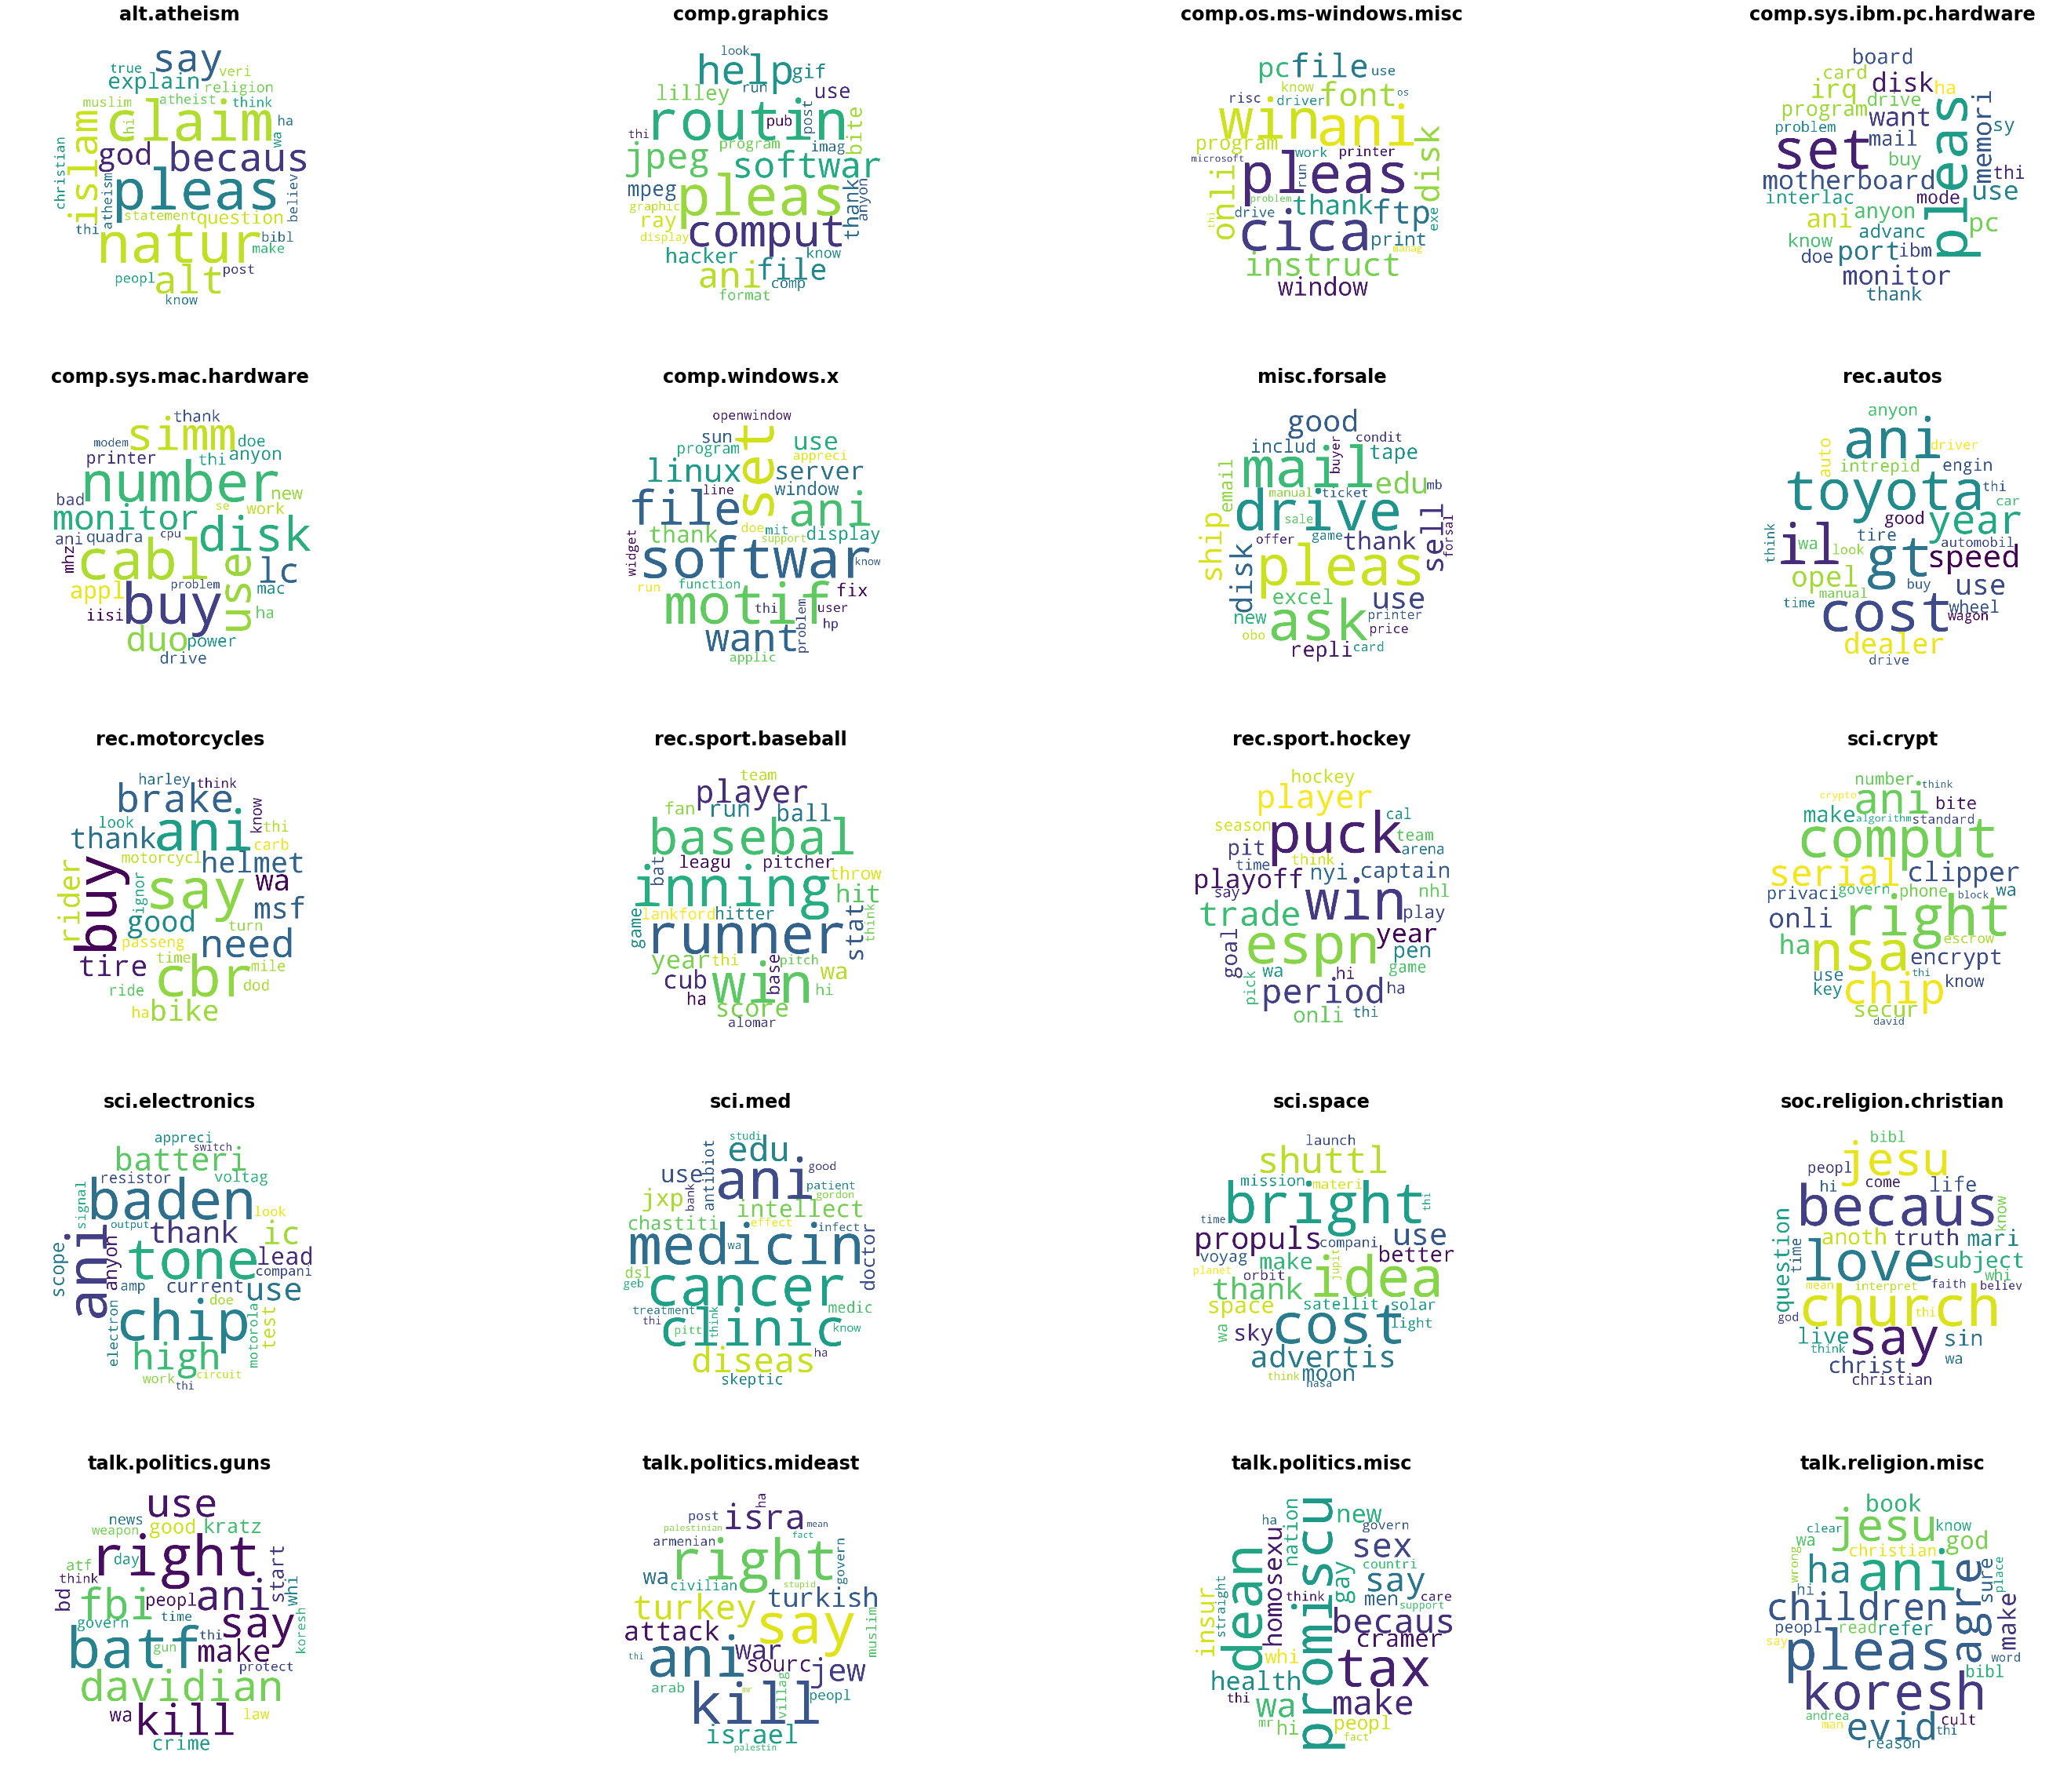

In [13]:
show_topK(nb_clf, vectorizer, category_names, K=30) # keywords for each class by original NB classifier

alt.atheism: reason agre ha thing doe belief know mean argument whi ani statement atheism claim delet believ make post object exist islam religion atheist peopl think wa moral say god thi
comp.graphics: inform edu help like window display softwar need convert doe email color gif ftp bite comput mail anyon look know use program ani format pleas thi thank file graphic imag
comp.os.ms-windows.misc: anyon microsoft doe like directori ha cica pc pleas ms know win ftp problem work thank print run ani printer disk os version font program thi driver use file window
comp.sys.ibm.pc.hardware: bio need motherboard video ha window work pleas dx board port pc doe control anyon driver disk know monitor problem ide mb bu ani thank use scsi thi drive card
comp.sys.mac.hardware: mb new doe cpu upgrad power machin cabl card speed centri price anyon ha quadra know modem lc ani work problem thank monitor mhz use drive simm thi mac appl
comp.windows.x: code ha compil user anyon set client mit tri know help

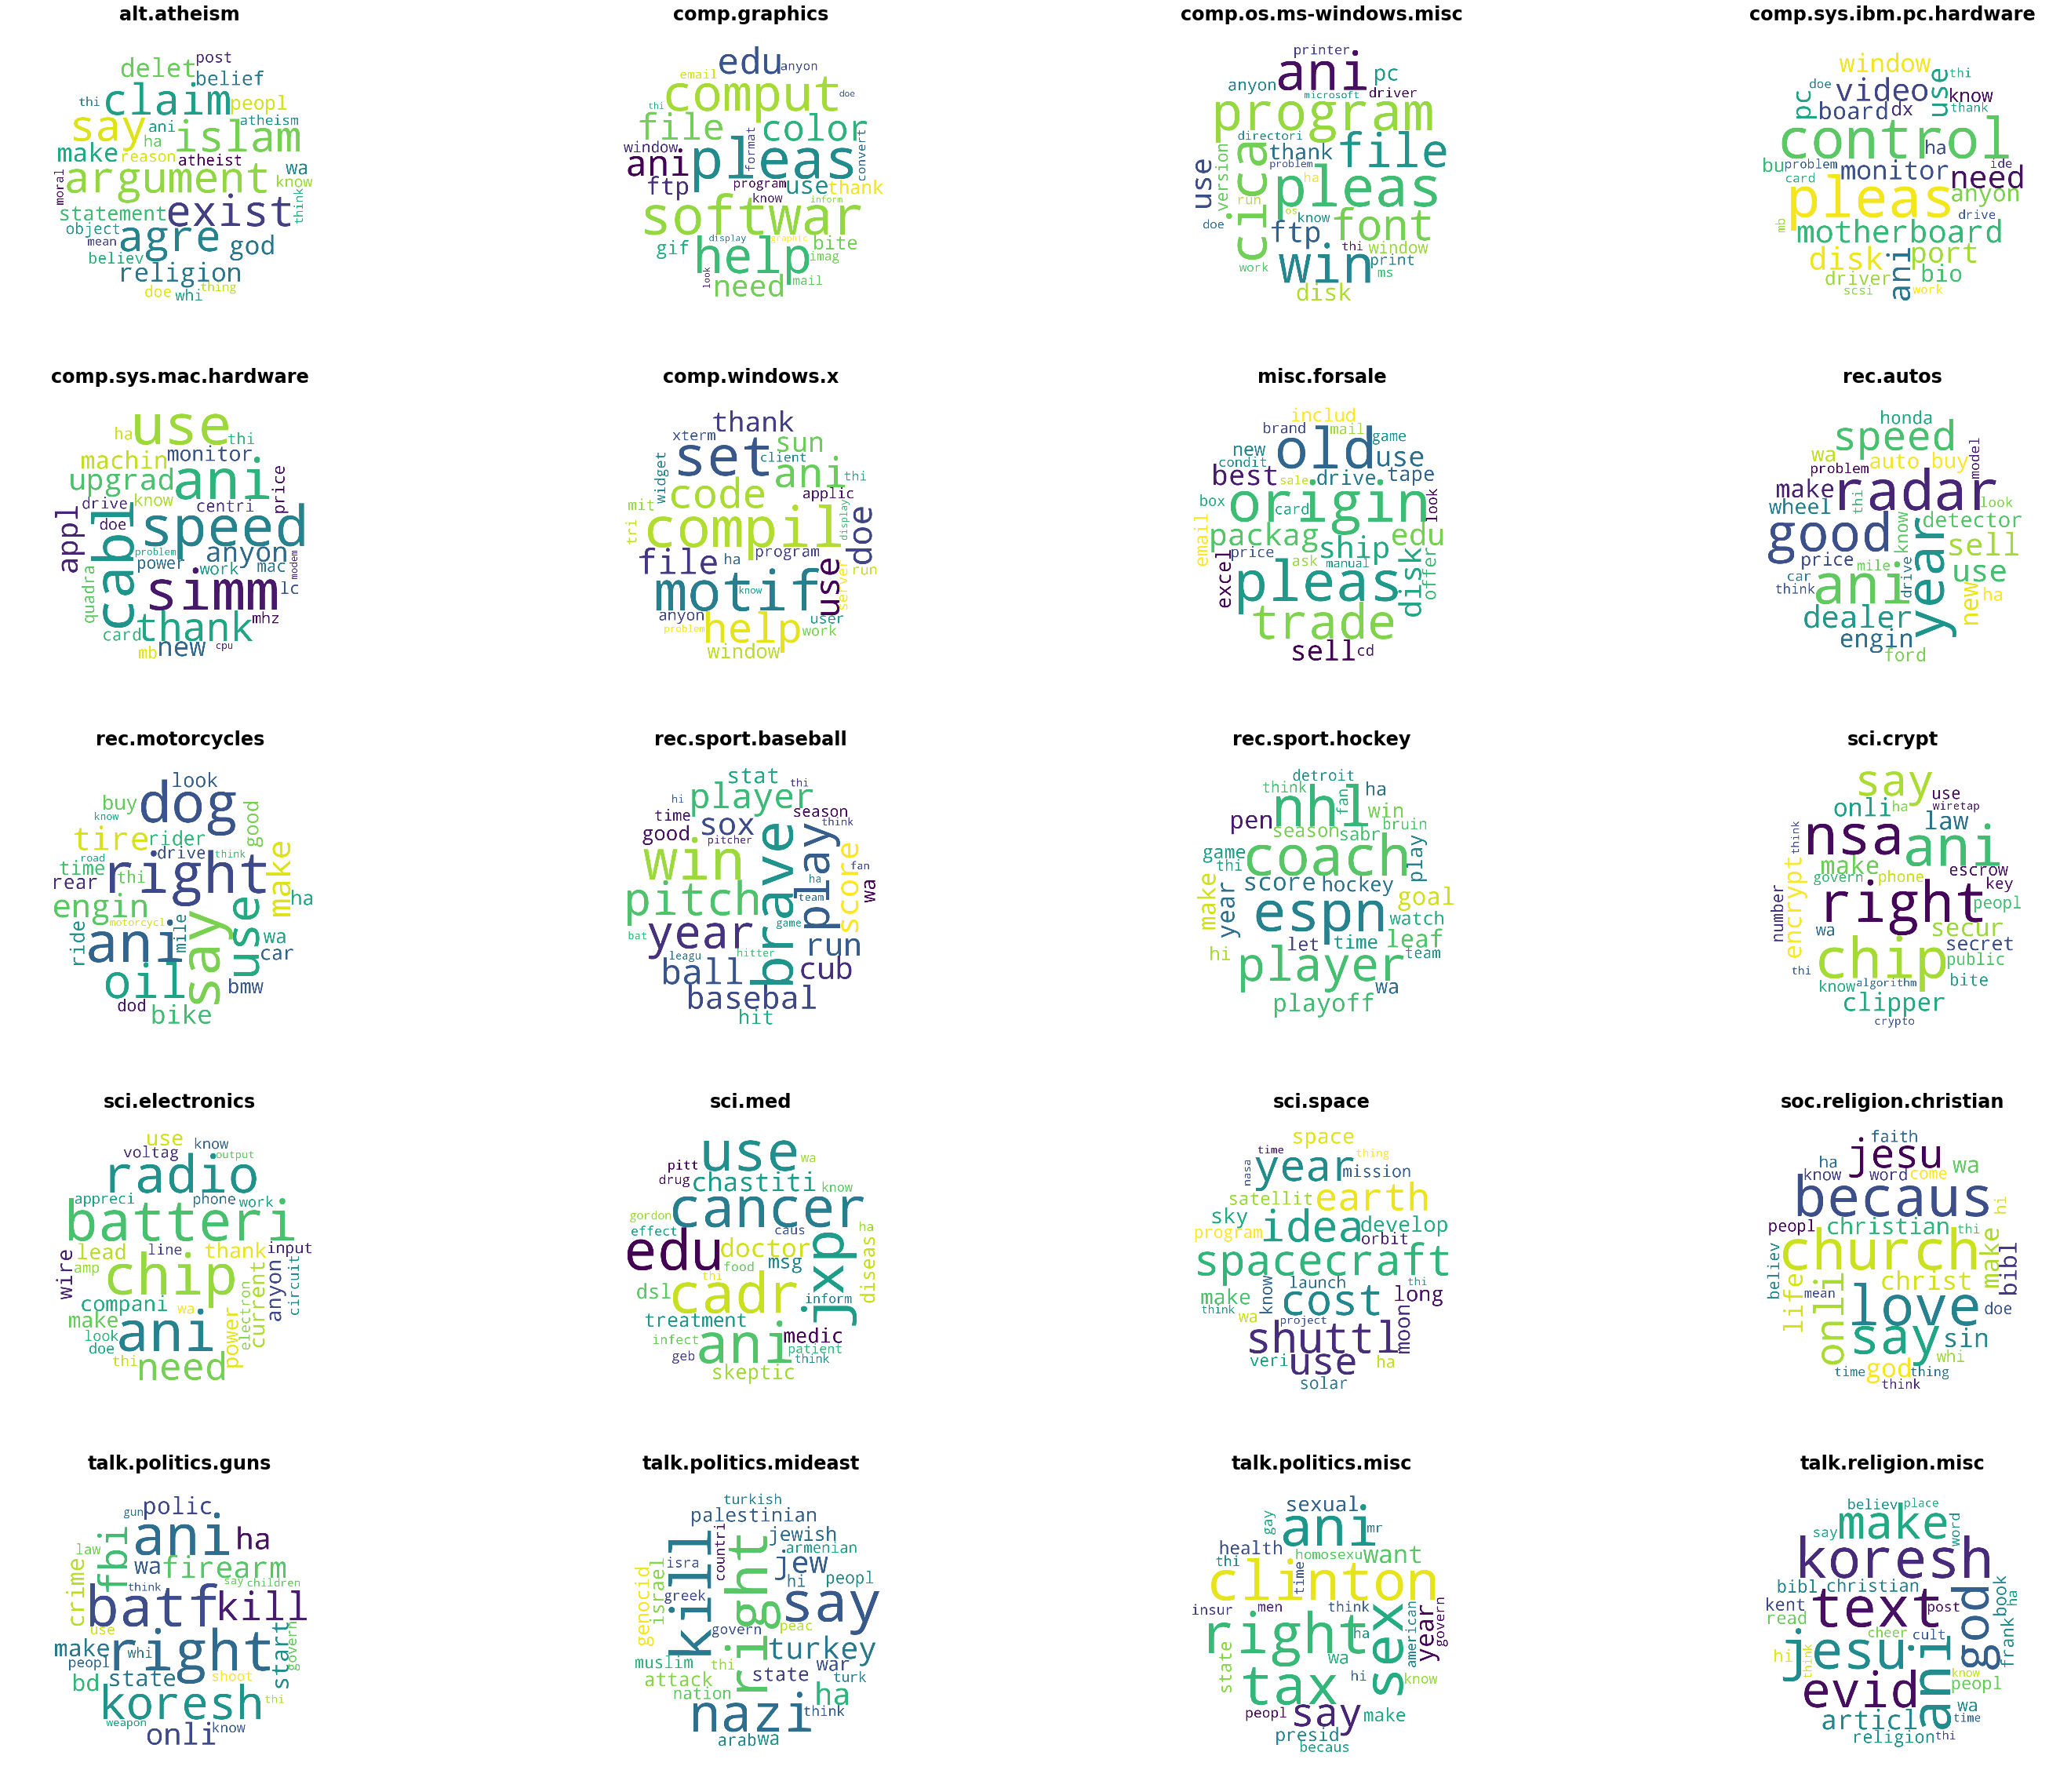

In [14]:
show_topK(em_nb_clf, vectorizer, category_names, K=30) # keywords for each class by semisupervised EM NB classifier